---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Applied Machine Learning in Python Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

There are two data files provided for use in training and validating models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv (features we can use in our model)

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only (highly correlated to compliance)

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

In this research, we will only use the training data to built and evalute the model, since compliance value is not given in test file.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

## Feature Importance
In this part we will calculate the feature importance by RandomForest for training data
During all the given features, we removed several features in our research for following reasons:

violation_zip_code, non_us_str_code - left blank
country - only have one value: USA
inspector_name, violator_name, violation_street_name, mailing_address_str_name, violation_description - considered highly correlated with other numeric features

For ticket_issued_date and hearing_date, we calculate the date difference between them


In [3]:
def feature_importance():
    cols = ['ticket_id','agency_name','violation_street_number','mailing_address_str_number','state',
           'ticket_issued_date','hearing_date','disposition','fine_amount','admin_fee','state_fee','late_fee','discount_amount',
           'clean_up_cost','judgment_amount']
    train_FI = pd.read_csv('train.csv', usecols=cols+['compliance'])
    address_FI = pd.read_csv('addresses.csv')
    latlon_FI = pd.read_csv('latlons.csv')

    address2_FI = address_FI.merge(latlon_FI, how = 'inner', on = ['address'])
    train2_FI = train_FI.merge(address2_FI, how = 'inner', on = ['ticket_id'])
    
    train2_FI = train2_FI.loc[train2_FI['compliance'].notnull()]
    train2_FI.fillna(0, inplace=True)
        
    train2_FI['diff'] = pd.to_datetime(train2_FI['hearing_date']) - pd.to_datetime(train2_FI['ticket_issued_date'])
    train2_FI['diff'] = np.array(train2_FI['diff']).astype(int)
    
    cleanup_nums = {'agency_name': {'Neighborhood City Halls': 1, 'Health Department': 2, 'Detroit Police Department': 3, 'Department of Public Works': 4, 'Buildings, Safety Engineering & Env Department': 5},
                    'state': {'AK': 1, 'AL': 2, 'AR': 3, 'AZ': 4, 'BC': 5, 'BL': 6, 'CA': 7, 'CO': 8, 'CT': 9, 'DC': 10, 'DE': 11, 'FL': 12, 'GA': 13, 'HI': 14, 'IA': 15, 'ID': 16, 'IL': 17, 'IN': 18, 'KS': 19, 'KY': 20,
                             'LA': 21, 'MA': 22, 'MD': 23, 'ME': 24, 'MI': 25, 'MN': 26, 'MO': 27, 'MS': 28, 'MT': 29, 'NB': 30, 'NC': 31, 'ND': 32, 'NH': 33, 'NJ': 34, 'NM': 35, 'NV': 36, 'NY': 37, 'OH': 38, 'OK': 39, 'ON': 40,
                             'OR': 41, 'PA': 42, 'PR': 43, 'QC': 44, 'QL': 45, 'RI': 46, 'SC': 47, 'SD': 48, 'TN': 49, 'TX': 50, 'UK': 51, 'UT': 52, 'VA': 53, 'VI': 54, 'VT': 55, 'WA': 56, 'WI': 57, 'WV': 58, 'WY': 59},
                    'disposition': {'Not responsible by City Dismissal': 1, 'Not responsible by Determination': 2, 'Not responsible by Dismissal': 3, 'PENDING JUDGMENT': 4,
                                   'Responsible (Fine Waived) by Deter': 5, 'Responsible by Admission': 6, 'Responsible by Default': 7, 'Responsible by Determination': 8, 'SET-ASIDE (PENDING JUDGMENT)': 9}}
    train2_FI.replace(cleanup_nums, inplace=True)
    
    y_train_FI = train2_FI[['compliance']].copy()
    X_train_FI = train2_FI.drop('ticket_id',axis=1)
    X_train_FI = X_train_FI.drop('compliance',axis=1)
    X_train_FI = X_train_FI.drop('ticket_issued_date',axis=1)
    X_train_FI = X_train_FI.drop('hearing_date',axis=1)
    X_train_FI = X_train_FI.drop('address',axis=1)
        
    clf = RandomForestClassifier()
    clf.fit(X_train_FI, y_train_FI)

    importance = clf.feature_importances_
    index=list(X_train_FI.columns.values)
    answer = pd.Series(data=importance,index=index,dtype='float32')
    
    return answer
feature_importance()

C:\Users\xinyu\Anaconda2\lib\site-packages\ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


agency_name                   0.010176
violation_street_number       0.136422
mailing_address_str_number    0.135613
state                         0.015144
disposition                   0.076575
fine_amount                   0.015588
admin_fee                     0.000000
state_fee                     0.000000
late_fee                      0.108863
discount_amount               0.055107
clean_up_cost                 0.000000
judgment_amount               0.024747
lat                           0.135974
lon                           0.139999
diff                          0.145793
dtype: float32

## Modeling and Evaluation
From the feature importance given, following six features are selected for our model:
violation_street_number, mailing_address_str_number, late_fee, lat, lon and difference of data 

The model is built with GradientBoostingClassifier and the parameters are fixed by GridSearchCV

The evaluation metric for this research is the Area Under the ROC Curve (AUC).

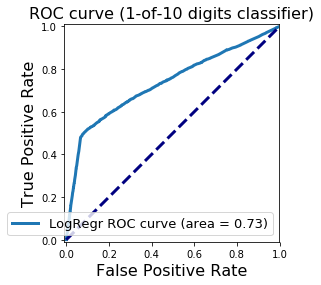

0.73474826572101715

In [2]:
def blight_model():
    cols = ['ticket_id','violation_street_number','mailing_address_str_number','late_fee','ticket_issued_date','hearing_date']
    train = pd.read_csv('train.csv', usecols=cols+['compliance'])
    address = pd.read_csv('addresses.csv')
    latlon = pd.read_csv('latlons.csv')
    
    address2 = address.merge(latlon, how = 'inner', on = ['address'])
    train2 = train.merge(address2, how = 'inner', on = ['ticket_id'])
    
    
    train2 = train2.loc[train2['compliance'].notnull()]
    train2.fillna(0, inplace=True)
    
    train2['diff'] = pd.to_datetime(train2['hearing_date']) - pd.to_datetime(train2['ticket_issued_date'])
    train2['diff'] = np.array(train2['diff']).astype(int)    

    
    X_train = train2[['violation_street_number','mailing_address_str_number','late_fee','lat','lon','diff']].copy()
    y_train = train2[['compliance']].copy()

    scaler = preprocessing.MinMaxScaler()    
    X_train = scaler.fit_transform(X_train)

    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, random_state = 0)
    
    parameters = {'max_features':[1,2,3,4,5], 'max_depth':[1,2,3,4,5]}
    GBC = GradientBoostingClassifier()
    clf = GridSearchCV(GBC, parameters)
    clf.fit(X_train2, y_train2.values.ravel())
    
    y_score_fit = clf.predict_proba(X_test2)[:,1]
    fpr_fit, tpr_fit, _ = roc_curve(y_test2, y_score_fit)
    roc_auc_fit = auc(fpr_fit, tpr_fit)
       
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_fit, tpr_fit, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_fit))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    
    return roc_auc_fit
blight_model()